## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras import optimizers
from keras.regularizers import l1, l2, l1_l2
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
#     BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                        beta_initializer='zeros', gamma_initializer='ones', 
#                        moving_mean_initializer='zeros', moving_variance_initializer='ones', 
#                        beta_regularizer=None, gamma_regularizer=None, 
#                        beta_constraint=None, gamma_constraint=None)

In [6]:
def build_mlp(input_data_shape, dropout_rate):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=256, kernel_size=(3, 3), input_shape=input_data_shape, padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層3
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層4
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(1e-4)))

    return model

In [7]:
## 超參數設定
OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
LEARNING_RATE = 1e-4
L2_EXP = 1e-4
DROPOUT = 0.0
EPOCHS = 100
BATCH_SIZE = [8, 16, 32, 128, 256]
MOMENTUM = 0.95

In [8]:
tra_loss = defaultdict(list)
val_loss = defaultdict(list)
tra_accu = defaultdict(list)
val_accu = defaultdict(list)

for i, bs in enumerate(BATCH_SIZE):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, ls=%.6f, dr=%.2f, bs=%d" % (optr, LEARNING_RATE, DROPOUT, bs))
        
        # create model
        model = build_mlp(x_train.shape[1:], DROPOUT)
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=0.0)
    
        # compile model and training
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, epochs=EPOCHS, batch_size=bs, 
                  validation_data=(x_test, y_test), shuffle=True)

        # Collect results
        exp_tag = "%s:%s" % (("bs_"+str(i)), str(optr))
        tra_loss[exp_tag].append(model.history.history["loss"])
        val_loss[exp_tag].append(model.history.history["val_loss"])
        
        tra_accu[exp_tag].append(model.history.history["acc"])
        val_accu[exp_tag].append(model.history.history["val_acc"])


Experiment with Optimizer=sgd, ls=0.000100, dr=0.00, bs=8
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 129s 3ms/step - loss: 1.4544 - acc: 0.5270 - val_loss: 1.1882 - val_acc: 0.6198
Epoch 2/100
50000/50000 [==============================] - 127s 3ms/step - loss: 1.0377 - acc: 0.6708 - val_loss: 1.0430 - val_acc: 0.6710
Epoch 3/100
50000/50000 [==============================] - 127s 3ms/step - loss: 0.8465 - acc: 0.7379 - val_loss: 1.0713 - val_acc: 0.6688
Epoch 4/100
50000/50000 [==============================] - 128s 3ms/step - loss: 0.6960 - acc: 0.7928 - val_loss: 1.0043 - val_acc: 0.6939
Epoch 5/100
50000/50000 [==============================] - 128s 3ms/step - loss: 0.5605 - acc: 0.8432 - val_loss: 0.9518 - val_acc: 0.7132
Epoch 6/100
50000/50000 [==============================] - 127s 3ms/step - loss: 0.4389 - acc: 0.8902 - val_loss: 1.0117 - val_acc: 0.7138
Epoch 7/100
50000/50000 [==============================] -

Epoch 59/100
50000/50000 [==============================] - 126s 3ms/step - loss: 0.0886 - acc: 1.0000 - val_loss: 1.2211 - val_acc: 0.7635
Epoch 60/100
50000/50000 [==============================] - 126s 3ms/step - loss: 0.0883 - acc: 1.0000 - val_loss: 1.2221 - val_acc: 0.7608
Epoch 61/100
50000/50000 [==============================] - 126s 3ms/step - loss: 0.0881 - acc: 1.0000 - val_loss: 1.2270 - val_acc: 0.7614
Epoch 62/100
50000/50000 [==============================] - 125s 3ms/step - loss: 0.0878 - acc: 1.0000 - val_loss: 1.2204 - val_acc: 0.7614
Epoch 63/100
50000/50000 [==============================] - 125s 3ms/step - loss: 0.0874 - acc: 1.0000 - val_loss: 1.2177 - val_acc: 0.7613
Epoch 64/100
50000/50000 [==============================] - 125s 3ms/step - loss: 0.0872 - acc: 1.0000 - val_loss: 1.2255 - val_acc: 0.7610
Epoch 65/100
50000/50000 [==============================] - 125s 3ms/step - loss: 0.0869 - acc: 1.0000 - val_loss: 1.2256 - val_acc: 0.7622
Epoch 66/100
50000/5

50000/50000 [==============================] - 140s 3ms/step - loss: 0.1849 - acc: 0.9737 - val_loss: 1.7762 - val_acc: 0.7278
Epoch 17/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.1744 - acc: 0.9757 - val_loss: 1.9555 - val_acc: 0.7365
Epoch 18/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.1641 - acc: 0.9779 - val_loss: 1.4827 - val_acc: 0.7465
Epoch 19/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.1561 - acc: 0.9798 - val_loss: 1.6923 - val_acc: 0.7367
Epoch 20/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.1477 - acc: 0.9804 - val_loss: 1.8993 - val_acc: 0.7511
Epoch 21/100
50000/50000 [==============================] - 140s 3ms/step - loss: 0.1453 - acc: 0.9803 - val_loss: 1.2587 - val_acc: 0.7232
Epoch 22/100
50000/50000 [==============================] - 140s 3ms/step - loss: 0.1394 - acc: 0.9823 - val_loss: 1.9210 - val_acc: 0.7333
Epoch 23/100
50000/50000 [=======

50000/50000 [==============================] - 141s 3ms/step - loss: 0.0693 - acc: 0.9917 - val_loss: 1.5394 - val_acc: 0.7455
Epoch 75/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.0685 - acc: 0.9922 - val_loss: 1.5120 - val_acc: 0.7428
Epoch 76/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.0716 - acc: 0.9909 - val_loss: 1.9186 - val_acc: 0.7393
Epoch 77/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.0715 - acc: 0.9909 - val_loss: 1.8621 - val_acc: 0.7428
Epoch 78/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.0698 - acc: 0.9911 - val_loss: 1.7489 - val_acc: 0.7359
Epoch 79/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.0686 - acc: 0.9914 - val_loss: 2.0648 - val_acc: 0.7338
Epoch 80/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.0700 - acc: 0.9911 - val_loss: 1.6269 - val_acc: 0.7493
Epoch 81/100
50000/50000 [=======

Epoch 32/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1396 - acc: 0.9923 - val_loss: 1.5731 - val_acc: 0.7445
Epoch 33/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1394 - acc: 0.9913 - val_loss: 1.7967 - val_acc: 0.7237
Epoch 34/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1402 - acc: 0.9910 - val_loss: 1.5365 - val_acc: 0.7434
Epoch 35/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1333 - acc: 0.9930 - val_loss: 1.5547 - val_acc: 0.7349
Epoch 36/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1369 - acc: 0.9911 - val_loss: 1.5931 - val_acc: 0.7386
Epoch 37/100
50000/50000 [==============================] - 154s 3ms/step - loss: 0.1369 - acc: 0.9913 - val_loss: 1.7133 - val_acc: 0.7414
Epoch 38/100
50000/50000 [==============================] - 154s 3ms/step - loss: 0.1346 - acc: 0.9921 - val_loss: 1.5957 - val_acc: 0.7417
Epoch 39/100
50000/5

50000/50000 [==============================] - 153s 3ms/step - loss: 0.1067 - acc: 0.9935 - val_loss: 1.6982 - val_acc: 0.7447
Epoch 91/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1049 - acc: 0.9937 - val_loss: 1.7780 - val_acc: 0.7517
Epoch 92/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1061 - acc: 0.9941 - val_loss: 2.0110 - val_acc: 0.7376
Epoch 93/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1062 - acc: 0.9938 - val_loss: 1.6397 - val_acc: 0.7417
Epoch 94/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1029 - acc: 0.9944 - val_loss: 1.6885 - val_acc: 0.7459
Epoch 95/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1054 - acc: 0.9933 - val_loss: 1.6932 - val_acc: 0.7460
Epoch 96/100
50000/50000 [==============================] - 153s 3ms/step - loss: 0.1015 - acc: 0.9949 - val_loss: 1.6745 - val_acc: 0.7365
Epoch 97/100
50000/50000 [=======

50000/50000 [==============================] - 134s 3ms/step - loss: 0.8331 - acc: 0.7547 - val_loss: 1.0809 - val_acc: 0.6554
Epoch 48/100
50000/50000 [==============================] - 134s 3ms/step - loss: 0.8303 - acc: 0.7559 - val_loss: 1.0801 - val_acc: 0.6575
Epoch 49/100
50000/50000 [==============================] - 134s 3ms/step - loss: 0.8262 - acc: 0.7585 - val_loss: 1.0777 - val_acc: 0.6573
Epoch 50/100
50000/50000 [==============================] - 134s 3ms/step - loss: 0.8231 - acc: 0.7596 - val_loss: 1.0763 - val_acc: 0.6575
Epoch 51/100
50000/50000 [==============================] - 134s 3ms/step - loss: 0.8180 - acc: 0.7621 - val_loss: 1.0740 - val_acc: 0.6585
Epoch 52/100
50000/50000 [==============================] - 134s 3ms/step - loss: 0.8135 - acc: 0.7633 - val_loss: 1.0732 - val_acc: 0.6605
Epoch 53/100
50000/50000 [==============================] - 134s 3ms/step - loss: 0.8097 - acc: 0.7639 - val_loss: 1.0705 - val_acc: 0.6596
Epoch 54/100
50000/50000 [=======

Epoch 5/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.6537 - acc: 0.8119 - val_loss: 1.0404 - val_acc: 0.6797
Epoch 6/100
50000/50000 [==============================] - 78s 2ms/step - loss: 0.5544 - acc: 0.8480 - val_loss: 1.0595 - val_acc: 0.6850
Epoch 7/100
50000/50000 [==============================] - 78s 2ms/step - loss: 0.4671 - acc: 0.8824 - val_loss: 0.9622 - val_acc: 0.7181
Epoch 8/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.3869 - acc: 0.9132 - val_loss: 0.9999 - val_acc: 0.7146
Epoch 9/100
50000/50000 [==============================] - 80s 2ms/step - loss: 0.3165 - acc: 0.9402 - val_loss: 0.9887 - val_acc: 0.7259
Epoch 10/100
50000/50000 [==============================] - 80s 2ms/step - loss: 0.2598 - acc: 0.9612 - val_loss: 1.1276 - val_acc: 0.6999
Epoch 11/100
50000/50000 [==============================] - 80s 2ms/step - loss: 0.2153 - acc: 0.9763 - val_loss: 0.9982 - val_acc: 0.7380
Epoch 12/100
50000/50000 [======

Epoch 64/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.0949 - acc: 1.0000 - val_loss: 1.2422 - val_acc: 0.7571
Epoch 65/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.0947 - acc: 1.0000 - val_loss: 1.2343 - val_acc: 0.7568
Epoch 66/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.0945 - acc: 1.0000 - val_loss: 1.2372 - val_acc: 0.7554
Epoch 67/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.0943 - acc: 1.0000 - val_loss: 1.2355 - val_acc: 0.7569
Epoch 68/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.0941 - acc: 1.0000 - val_loss: 1.2370 - val_acc: 0.7574
Epoch 69/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.0940 - acc: 1.0000 - val_loss: 1.2395 - val_acc: 0.7558
Epoch 70/100
50000/50000 [==============================] - 79s 2ms/step - loss: 0.0937 - acc: 1.0000 - val_loss: 1.2344 - val_acc: 0.7566
Epoch 71/100
50000/50000 [=

50000/50000 [==============================] - 86s 2ms/step - loss: 0.1027 - acc: 0.9905 - val_loss: 1.6652 - val_acc: 0.7449
Epoch 23/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.1034 - acc: 0.9901 - val_loss: 1.2561 - val_acc: 0.7281
Epoch 24/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.1000 - acc: 0.9899 - val_loss: 1.5817 - val_acc: 0.7455
Epoch 25/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0952 - acc: 0.9904 - val_loss: 1.6867 - val_acc: 0.7514
Epoch 26/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0937 - acc: 0.9907 - val_loss: 1.4294 - val_acc: 0.7536
Epoch 27/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0923 - acc: 0.9910 - val_loss: 1.4308 - val_acc: 0.7388
Epoch 28/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0885 - acc: 0.9917 - val_loss: 2.4865 - val_acc: 0.7213
Epoch 29/100
50000/50000 [==============

50000/50000 [==============================] - 86s 2ms/step - loss: 0.0515 - acc: 0.9947 - val_loss: 1.3979 - val_acc: 0.7476
Epoch 82/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0496 - acc: 0.9955 - val_loss: 1.7643 - val_acc: 0.7290
Epoch 83/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0518 - acc: 0.9948 - val_loss: 1.2017 - val_acc: 0.7283
Epoch 84/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0507 - acc: 0.9948 - val_loss: 1.9623 - val_acc: 0.7248
Epoch 85/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0502 - acc: 0.9952 - val_loss: 1.6610 - val_acc: 0.7448
Epoch 86/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0499 - acc: 0.9952 - val_loss: 1.3799 - val_acc: 0.7421
Epoch 87/100
50000/50000 [==============================] - 86s 2ms/step - loss: 0.0497 - acc: 0.9952 - val_loss: 1.2830 - val_acc: 0.7354
Epoch 88/100
50000/50000 [==============

50000/50000 [==============================] - 92s 2ms/step - loss: 0.1130 - acc: 0.9940 - val_loss: 1.4704 - val_acc: 0.7555
Epoch 40/100
50000/50000 [==============================] - 92s 2ms/step - loss: 0.1101 - acc: 0.9947 - val_loss: 1.6013 - val_acc: 0.7389
Epoch 41/100
50000/50000 [==============================] - 93s 2ms/step - loss: 0.1118 - acc: 0.9940 - val_loss: 1.5273 - val_acc: 0.7348
Epoch 42/100
50000/50000 [==============================] - 93s 2ms/step - loss: 0.1090 - acc: 0.9950 - val_loss: 1.5464 - val_acc: 0.7460
Epoch 43/100
50000/50000 [==============================] - 92s 2ms/step - loss: 0.1091 - acc: 0.9943 - val_loss: 1.5108 - val_acc: 0.7488
Epoch 44/100
50000/50000 [==============================] - 92s 2ms/step - loss: 0.1068 - acc: 0.9954 - val_loss: 1.6998 - val_acc: 0.7343
Epoch 45/100
50000/50000 [==============================] - 92s 2ms/step - loss: 0.1072 - acc: 0.9945 - val_loss: 1.5726 - val_acc: 0.7350
Epoch 46/100
50000/50000 [==============

50000/50000 [==============================] - 93s 2ms/step - loss: 0.0803 - acc: 0.9970 - val_loss: 1.8805 - val_acc: 0.7273
Epoch 99/100
50000/50000 [==============================] - 93s 2ms/step - loss: 0.0811 - acc: 0.9966 - val_loss: 1.6734 - val_acc: 0.7516
Epoch 100/100
50000/50000 [==============================] - 93s 2ms/step - loss: 0.0804 - acc: 0.9965 - val_loss: 1.4760 - val_acc: 0.7397
Experiment with Optimizer=adagrad, ls=0.000100, dr=0.00, bs=16
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 83s 2ms/step - loss: 1.6754 - acc: 0.4504 - val_loss: 1.5015 - val_acc: 0.5067
Epoch 2/100
50000/50000 [==============================] - 82s 2ms/step - loss: 1.4231 - acc: 0.5378 - val_loss: 1.4178 - val_acc: 0.5335
Epoch 3/100
50000/50000 [==============================] - 82s 2ms/step - loss: 1.3400 - acc: 0.5701 - val_loss: 1.3684 - val_acc: 0.5523
Epoch 4/100
50000/50000 [==============================] - 82s 2ms/s

50000/50000 [==============================] - 82s 2ms/step - loss: 0.7915 - acc: 0.7730 - val_loss: 1.0641 - val_acc: 0.6664
Epoch 57/100
50000/50000 [==============================] - 82s 2ms/step - loss: 0.7880 - acc: 0.7765 - val_loss: 1.0622 - val_acc: 0.6661
Epoch 58/100
50000/50000 [==============================] - 82s 2ms/step - loss: 0.7859 - acc: 0.7742 - val_loss: 1.0610 - val_acc: 0.6655
Epoch 59/100
50000/50000 [==============================] - 82s 2ms/step - loss: 0.7828 - acc: 0.7754 - val_loss: 1.0600 - val_acc: 0.6667
Epoch 60/100
50000/50000 [==============================] - 82s 2ms/step - loss: 0.7805 - acc: 0.7768 - val_loss: 1.0593 - val_acc: 0.6647
Epoch 61/100
50000/50000 [==============================] - 82s 2ms/step - loss: 0.7756 - acc: 0.7800 - val_loss: 1.0578 - val_acc: 0.6661
Epoch 62/100
50000/50000 [==============================] - 82s 2ms/step - loss: 0.7721 - acc: 0.7811 - val_loss: 1.0562 - val_acc: 0.6680
Epoch 63/100
50000/50000 [==============

50000/50000 [==============================] - 55s 1ms/step - loss: 0.2688 - acc: 0.9623 - val_loss: 1.0552 - val_acc: 0.7051
Epoch 15/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.2390 - acc: 0.9734 - val_loss: 1.0095 - val_acc: 0.7319
Epoch 16/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.2143 - acc: 0.9808 - val_loss: 0.9958 - val_acc: 0.7326
Epoch 17/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.1942 - acc: 0.9872 - val_loss: 1.0092 - val_acc: 0.7346
Epoch 18/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.1777 - acc: 0.9917 - val_loss: 1.0557 - val_acc: 0.7327
Epoch 19/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.1658 - acc: 0.9941 - val_loss: 1.0214 - val_acc: 0.7435
Epoch 20/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.1555 - acc: 0.9958 - val_loss: 1.1248 - val_acc: 0.7230
Epoch 21/100
50000/50000 [==============

50000/50000 [==============================] - 55s 1ms/step - loss: 0.0996 - acc: 1.0000 - val_loss: 1.2298 - val_acc: 0.7513
Epoch 74/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.0995 - acc: 1.0000 - val_loss: 1.2316 - val_acc: 0.7516
Epoch 75/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.0993 - acc: 1.0000 - val_loss: 1.2299 - val_acc: 0.7525
Epoch 76/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.0991 - acc: 1.0000 - val_loss: 1.2310 - val_acc: 0.7524
Epoch 77/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.0990 - acc: 1.0000 - val_loss: 1.2333 - val_acc: 0.7519
Epoch 78/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.0989 - acc: 1.0000 - val_loss: 1.2331 - val_acc: 0.7542
Epoch 79/100
50000/50000 [==============================] - 55s 1ms/step - loss: 0.0988 - acc: 1.0000 - val_loss: 1.2365 - val_acc: 0.7514
Epoch 80/100
50000/50000 [==============

50000/50000 [==============================] - 58s 1ms/step - loss: 0.0725 - acc: 0.9946 - val_loss: 1.6824 - val_acc: 0.7451
Epoch 32/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0705 - acc: 0.9950 - val_loss: 1.5195 - val_acc: 0.7472
Epoch 33/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0696 - acc: 0.9949 - val_loss: 1.4405 - val_acc: 0.7284
Epoch 34/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0688 - acc: 0.9947 - val_loss: 1.6700 - val_acc: 0.7504
Epoch 35/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0675 - acc: 0.9949 - val_loss: 1.2540 - val_acc: 0.7496
Epoch 36/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0682 - acc: 0.9945 - val_loss: 1.2088 - val_acc: 0.7170
Epoch 37/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0665 - acc: 0.9950 - val_loss: 2.0933 - val_acc: 0.7280
Epoch 38/100
50000/50000 [==============

50000/50000 [==============================] - 58s 1ms/step - loss: 0.0408 - acc: 0.9970 - val_loss: 1.4710 - val_acc: 0.7485
Epoch 91/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0402 - acc: 0.9967 - val_loss: 1.8350 - val_acc: 0.7444
Epoch 92/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0406 - acc: 0.9967 - val_loss: 1.1822 - val_acc: 0.7431
Epoch 93/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0406 - acc: 0.9967 - val_loss: 1.2755 - val_acc: 0.7542
Epoch 94/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0386 - acc: 0.9973 - val_loss: 1.4763 - val_acc: 0.7580
Epoch 95/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0386 - acc: 0.9972 - val_loss: 1.4438 - val_acc: 0.7471
Epoch 96/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0376 - acc: 0.9973 - val_loss: 1.4400 - val_acc: 0.7414
Epoch 97/100
50000/50000 [==============

50000/50000 [==============================] - 61s 1ms/step - loss: 0.0892 - acc: 0.9959 - val_loss: 1.4558 - val_acc: 0.7444
Epoch 49/100
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0887 - acc: 0.9960 - val_loss: 1.4982 - val_acc: 0.7405
Epoch 50/100
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0851 - acc: 0.9974 - val_loss: 1.6500 - val_acc: 0.7286
Epoch 51/100
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0839 - acc: 0.9973 - val_loss: 1.4088 - val_acc: 0.7517
Epoch 52/100
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0890 - acc: 0.9955 - val_loss: 1.5197 - val_acc: 0.7357
Epoch 53/100
50000/50000 [==============================] - 62s 1ms/step - loss: 0.0839 - acc: 0.9968 - val_loss: 1.5207 - val_acc: 0.7462
Epoch 54/100
50000/50000 [==============================] - 62s 1ms/step - loss: 0.0813 - acc: 0.9975 - val_loss: 1.4917 - val_acc: 0.7461
Epoch 55/100
50000/50000 [==============

50000/50000 [==============================] - 56s 1ms/step - loss: 1.1922 - acc: 0.6205 - val_loss: 1.2915 - val_acc: 0.5834
Epoch 7/100
50000/50000 [==============================] - 56s 1ms/step - loss: 1.1619 - acc: 0.6318 - val_loss: 1.2748 - val_acc: 0.5906
Epoch 8/100
50000/50000 [==============================] - 56s 1ms/step - loss: 1.1364 - acc: 0.6404 - val_loss: 1.2576 - val_acc: 0.5956
Epoch 9/100
50000/50000 [==============================] - 56s 1ms/step - loss: 1.1136 - acc: 0.6496 - val_loss: 1.2451 - val_acc: 0.6009
Epoch 10/100
50000/50000 [==============================] - 56s 1ms/step - loss: 1.0950 - acc: 0.6565 - val_loss: 1.2341 - val_acc: 0.6058
Epoch 11/100
50000/50000 [==============================] - 56s 1ms/step - loss: 1.0758 - acc: 0.6650 - val_loss: 1.2231 - val_acc: 0.6083
Epoch 12/100
50000/50000 [==============================] - 56s 1ms/step - loss: 1.0600 - acc: 0.6686 - val_loss: 1.2139 - val_acc: 0.6125
Epoch 13/100
50000/50000 [=================

50000/50000 [==============================] - 57s 1ms/step - loss: 0.7376 - acc: 0.7941 - val_loss: 1.0578 - val_acc: 0.6683
Epoch 66/100
50000/50000 [==============================] - 56s 1ms/step - loss: 0.7352 - acc: 0.7952 - val_loss: 1.0568 - val_acc: 0.6690
Epoch 67/100
50000/50000 [==============================] - 57s 1ms/step - loss: 0.7321 - acc: 0.7958 - val_loss: 1.0559 - val_acc: 0.6695
Epoch 68/100
50000/50000 [==============================] - 56s 1ms/step - loss: 0.7293 - acc: 0.7971 - val_loss: 1.0547 - val_acc: 0.6686
Epoch 69/100
50000/50000 [==============================] - 57s 1ms/step - loss: 0.7263 - acc: 0.7971 - val_loss: 1.0536 - val_acc: 0.6701
Epoch 70/100
50000/50000 [==============================] - 56s 1ms/step - loss: 0.7245 - acc: 0.7987 - val_loss: 1.0529 - val_acc: 0.6708
Epoch 71/100
50000/50000 [==============================] - 57s 1ms/step - loss: 0.7198 - acc: 0.8009 - val_loss: 1.0521 - val_acc: 0.6701
Epoch 72/100
50000/50000 [==============

Epoch 23/100
50000/50000 [==============================] - 37s 741us/step - loss: 0.4465 - acc: 0.8986 - val_loss: 1.0035 - val_acc: 0.7038
Epoch 24/100
50000/50000 [==============================] - 37s 741us/step - loss: 0.4255 - acc: 0.9078 - val_loss: 0.9927 - val_acc: 0.7098
Epoch 25/100
50000/50000 [==============================] - 37s 742us/step - loss: 0.4096 - acc: 0.9134 - val_loss: 1.1177 - val_acc: 0.6737
Epoch 26/100
50000/50000 [==============================] - 37s 741us/step - loss: 0.3925 - acc: 0.9213 - val_loss: 1.0702 - val_acc: 0.6869
Epoch 27/100
50000/50000 [==============================] - 37s 741us/step - loss: 0.3767 - acc: 0.9265 - val_loss: 1.0373 - val_acc: 0.6952
Epoch 28/100
50000/50000 [==============================] - 37s 742us/step - loss: 0.3596 - acc: 0.9342 - val_loss: 0.9880 - val_acc: 0.7130
Epoch 29/100
50000/50000 [==============================] - 37s 742us/step - loss: 0.3449 - acc: 0.9403 - val_loss: 1.0189 - val_acc: 0.7058
Epoch 30/100


50000/50000 [==============================] - 37s 742us/step - loss: 0.1196 - acc: 0.9999 - val_loss: 1.1917 - val_acc: 0.7291
Epoch 82/100
50000/50000 [==============================] - 37s 741us/step - loss: 0.1191 - acc: 1.0000 - val_loss: 1.1995 - val_acc: 0.7294
Epoch 83/100
50000/50000 [==============================] - 37s 741us/step - loss: 0.1185 - acc: 0.9999 - val_loss: 1.2039 - val_acc: 0.7297
Epoch 84/100
50000/50000 [==============================] - 37s 742us/step - loss: 0.1180 - acc: 1.0000 - val_loss: 1.2047 - val_acc: 0.7287
Epoch 85/100
50000/50000 [==============================] - 37s 742us/step - loss: 0.1176 - acc: 0.9999 - val_loss: 1.2196 - val_acc: 0.7272
Epoch 86/100
50000/50000 [==============================] - 37s 741us/step - loss: 0.1170 - acc: 1.0000 - val_loss: 1.2095 - val_acc: 0.7279
Epoch 87/100
50000/50000 [==============================] - 37s 742us/step - loss: 0.1165 - acc: 1.0000 - val_loss: 1.2064 - val_acc: 0.7263
Epoch 88/100
50000/50000 [

50000/50000 [==============================] - 38s 757us/step - loss: 0.0337 - acc: 0.9992 - val_loss: 1.4285 - val_acc: 0.7036
Epoch 39/100
50000/50000 [==============================] - 38s 757us/step - loss: 0.0334 - acc: 0.9992 - val_loss: 1.4186 - val_acc: 0.7387
Epoch 40/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0326 - acc: 0.9991 - val_loss: 1.4885 - val_acc: 0.7349
Epoch 41/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0322 - acc: 0.9992 - val_loss: 1.5547 - val_acc: 0.7336
Epoch 42/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0319 - acc: 0.9991 - val_loss: 1.4703 - val_acc: 0.7317
Epoch 43/100
50000/50000 [==============================] - 38s 759us/step - loss: 0.0309 - acc: 0.9991 - val_loss: 1.3263 - val_acc: 0.7428
Epoch 44/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0309 - acc: 0.9990 - val_loss: 1.6254 - val_acc: 0.7187
Epoch 45/100
50000/50000 [

50000/50000 [==============================] - 38s 757us/step - loss: 0.0290 - acc: 0.9987 - val_loss: 1.6740 - val_acc: 0.7472
Epoch 97/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0280 - acc: 0.9988 - val_loss: 1.3601 - val_acc: 0.7384
Epoch 98/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0272 - acc: 0.9991 - val_loss: 1.6817 - val_acc: 0.7440
Epoch 99/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0280 - acc: 0.9988 - val_loss: 1.8305 - val_acc: 0.7084
Epoch 100/100
50000/50000 [==============================] - 38s 758us/step - loss: 0.0274 - acc: 0.9989 - val_loss: 1.2959 - val_acc: 0.7626
Experiment with Optimizer=adam, ls=0.000100, dr=0.00, bs=128
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 39s 787us/step - loss: 1.4161 - acc: 0.5450 - val_loss: 1.1607 - val_acc: 0.6244
Epoch 2/100
50000/50000 [==============================]

50000/50000 [==============================] - 39s 773us/step - loss: 0.0357 - acc: 1.0000 - val_loss: 1.1120 - val_acc: 0.7743
Epoch 54/100
50000/50000 [==============================] - 39s 774us/step - loss: 0.0340 - acc: 1.0000 - val_loss: 1.1018 - val_acc: 0.7733
Epoch 55/100
50000/50000 [==============================] - 39s 774us/step - loss: 0.0321 - acc: 1.0000 - val_loss: 1.0906 - val_acc: 0.7727
Epoch 56/100
50000/50000 [==============================] - 39s 773us/step - loss: 0.0299 - acc: 1.0000 - val_loss: 1.0741 - val_acc: 0.7765
Epoch 57/100
50000/50000 [==============================] - 39s 774us/step - loss: 0.0277 - acc: 1.0000 - val_loss: 1.0592 - val_acc: 0.7740
Epoch 58/100
50000/50000 [==============================] - 39s 774us/step - loss: 0.0254 - acc: 1.0000 - val_loss: 1.0460 - val_acc: 0.7733
Epoch 59/100
50000/50000 [==============================] - 39s 773us/step - loss: 0.1772 - acc: 0.9504 - val_loss: 1.2364 - val_acc: 0.7199
Epoch 60/100
50000/50000 [

50000/50000 [==============================] - 37s 749us/step - loss: 1.0910 - acc: 0.6629 - val_loss: 1.2304 - val_acc: 0.5995
Epoch 11/100
50000/50000 [==============================] - 37s 750us/step - loss: 1.0731 - acc: 0.6698 - val_loss: 1.2195 - val_acc: 0.6044
Epoch 12/100
50000/50000 [==============================] - 37s 750us/step - loss: 1.0553 - acc: 0.6773 - val_loss: 1.2128 - val_acc: 0.6093
Epoch 13/100
50000/50000 [==============================] - 37s 749us/step - loss: 1.0423 - acc: 0.6820 - val_loss: 1.2026 - val_acc: 0.6101
Epoch 14/100
50000/50000 [==============================] - 37s 750us/step - loss: 1.0273 - acc: 0.6878 - val_loss: 1.1964 - val_acc: 0.6115
Epoch 15/100
50000/50000 [==============================] - 38s 750us/step - loss: 1.0147 - acc: 0.6917 - val_loss: 1.1875 - val_acc: 0.6169
Epoch 16/100
50000/50000 [==============================] - 37s 750us/step - loss: 1.0032 - acc: 0.6964 - val_loss: 1.1799 - val_acc: 0.6209
Epoch 17/100
50000/50000 [

50000/50000 [==============================] - 37s 749us/step - loss: 0.7260 - acc: 0.8003 - val_loss: 1.0527 - val_acc: 0.6683
Epoch 69/100
50000/50000 [==============================] - 37s 749us/step - loss: 0.7227 - acc: 0.8024 - val_loss: 1.0522 - val_acc: 0.6682
Epoch 70/100
50000/50000 [==============================] - 37s 749us/step - loss: 0.7201 - acc: 0.8033 - val_loss: 1.0523 - val_acc: 0.6689
Epoch 71/100
50000/50000 [==============================] - 38s 750us/step - loss: 0.7181 - acc: 0.8048 - val_loss: 1.0507 - val_acc: 0.6689
Epoch 72/100
50000/50000 [==============================] - 37s 750us/step - loss: 0.7154 - acc: 0.8056 - val_loss: 1.0500 - val_acc: 0.6697
Epoch 73/100
50000/50000 [==============================] - 38s 750us/step - loss: 0.7118 - acc: 0.8069 - val_loss: 1.0486 - val_acc: 0.6702
Epoch 74/100
50000/50000 [==============================] - 38s 750us/step - loss: 0.7093 - acc: 0.8082 - val_loss: 1.0474 - val_acc: 0.6710
Epoch 75/100
50000/50000 [

50000/50000 [==============================] - 34s 677us/step - loss: 0.6179 - acc: 0.8315 - val_loss: 1.0581 - val_acc: 0.6735
Epoch 26/100
50000/50000 [==============================] - 34s 677us/step - loss: 0.6026 - acc: 0.8379 - val_loss: 1.0524 - val_acc: 0.6829
Epoch 27/100
50000/50000 [==============================] - 34s 676us/step - loss: 0.5898 - acc: 0.8407 - val_loss: 1.0748 - val_acc: 0.6708
Epoch 28/100
50000/50000 [==============================] - 34s 676us/step - loss: 0.5735 - acc: 0.8489 - val_loss: 0.9991 - val_acc: 0.6978
Epoch 29/100
50000/50000 [==============================] - 34s 677us/step - loss: 0.5610 - acc: 0.8550 - val_loss: 1.0239 - val_acc: 0.6904
Epoch 30/100
50000/50000 [==============================] - 34s 677us/step - loss: 0.5486 - acc: 0.8605 - val_loss: 0.9891 - val_acc: 0.6968
Epoch 31/100
50000/50000 [==============================] - 34s 676us/step - loss: 0.5342 - acc: 0.8649 - val_loss: 0.9916 - val_acc: 0.6983
Epoch 32/100
50000/50000 [

50000/50000 [==============================] - 34s 678us/step - loss: 0.1814 - acc: 0.9945 - val_loss: 1.1074 - val_acc: 0.7123
Epoch 84/100
50000/50000 [==============================] - 34s 677us/step - loss: 0.1787 - acc: 0.9951 - val_loss: 1.1063 - val_acc: 0.7135
Epoch 85/100
50000/50000 [==============================] - 34s 676us/step - loss: 0.1763 - acc: 0.9957 - val_loss: 1.1135 - val_acc: 0.7154
Epoch 86/100
50000/50000 [==============================] - 34s 676us/step - loss: 0.1738 - acc: 0.9965 - val_loss: 1.1321 - val_acc: 0.7123
Epoch 87/100
50000/50000 [==============================] - 34s 676us/step - loss: 0.1719 - acc: 0.9963 - val_loss: 1.1203 - val_acc: 0.7127
Epoch 88/100
50000/50000 [==============================] - 34s 676us/step - loss: 0.1701 - acc: 0.9965 - val_loss: 1.1025 - val_acc: 0.7192
Epoch 89/100
50000/50000 [==============================] - 34s 677us/step - loss: 0.1682 - acc: 0.9967 - val_loss: 1.1012 - val_acc: 0.7178
Epoch 90/100
50000/50000 [

50000/50000 [==============================] - 34s 685us/step - loss: 0.0330 - acc: 0.9996 - val_loss: 1.2602 - val_acc: 0.7356
Epoch 41/100
50000/50000 [==============================] - 34s 685us/step - loss: 0.0313 - acc: 0.9998 - val_loss: 1.2167 - val_acc: 0.7366
Epoch 42/100
50000/50000 [==============================] - 34s 684us/step - loss: 0.0304 - acc: 0.9996 - val_loss: 1.4422 - val_acc: 0.7211
Epoch 43/100
50000/50000 [==============================] - 34s 684us/step - loss: 0.0299 - acc: 0.9995 - val_loss: 1.3448 - val_acc: 0.7270
Epoch 44/100
50000/50000 [==============================] - 34s 685us/step - loss: 0.0288 - acc: 0.9998 - val_loss: 1.6559 - val_acc: 0.6840
Epoch 45/100
50000/50000 [==============================] - 34s 685us/step - loss: 0.0283 - acc: 0.9995 - val_loss: 1.1498 - val_acc: 0.7486
Epoch 46/100
50000/50000 [==============================] - 34s 684us/step - loss: 0.0272 - acc: 0.9996 - val_loss: 1.2098 - val_acc: 0.7543
Epoch 47/100
50000/50000 [

50000/50000 [==============================] - 34s 685us/step - loss: 0.0160 - acc: 0.9996 - val_loss: 1.2705 - val_acc: 0.7303
Epoch 99/100
50000/50000 [==============================] - 34s 684us/step - loss: 0.0161 - acc: 0.9995 - val_loss: 1.2965 - val_acc: 0.7581
Epoch 100/100
50000/50000 [==============================] - 34s 684us/step - loss: 0.0160 - acc: 0.9996 - val_loss: 1.4070 - val_acc: 0.7333
Experiment with Optimizer=adam, ls=0.000100, dr=0.00, bs=256
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 35s 706us/step - loss: 1.4849 - acc: 0.5210 - val_loss: 1.2704 - val_acc: 0.5870
Epoch 2/100
50000/50000 [==============================] - 35s 693us/step - loss: 1.0199 - acc: 0.6814 - val_loss: 1.1225 - val_acc: 0.6419
Epoch 3/100
50000/50000 [==============================] - 35s 692us/step - loss: 0.8091 - acc: 0.7529 - val_loss: 1.1748 - val_acc: 0.6285
Epoch 4/100
50000/50000 [==============================] -

50000/50000 [==============================] - 35s 693us/step - loss: 0.1662 - acc: 0.9572 - val_loss: 1.1526 - val_acc: 0.7287
Epoch 56/100
50000/50000 [==============================] - 35s 692us/step - loss: 0.0578 - acc: 0.9971 - val_loss: 1.1361 - val_acc: 0.7547
Epoch 57/100
50000/50000 [==============================] - 35s 693us/step - loss: 0.0455 - acc: 0.9998 - val_loss: 1.1263 - val_acc: 0.7631
Epoch 58/100
50000/50000 [==============================] - 35s 693us/step - loss: 0.0423 - acc: 1.0000 - val_loss: 1.1451 - val_acc: 0.7609
Epoch 59/100
50000/50000 [==============================] - 35s 692us/step - loss: 0.0414 - acc: 1.0000 - val_loss: 1.1582 - val_acc: 0.7615
Epoch 60/100
50000/50000 [==============================] - 35s 692us/step - loss: 0.0406 - acc: 1.0000 - val_loss: 1.1683 - val_acc: 0.7634
Epoch 61/100
50000/50000 [==============================] - 35s 693us/step - loss: 0.0399 - acc: 1.0000 - val_loss: 1.1731 - val_acc: 0.7634
Epoch 62/100
50000/50000 [

50000/50000 [==============================] - 34s 680us/step - loss: 1.0677 - acc: 0.6678 - val_loss: 1.2235 - val_acc: 0.6020
Epoch 13/100
50000/50000 [==============================] - 34s 680us/step - loss: 1.0527 - acc: 0.6755 - val_loss: 1.2151 - val_acc: 0.6052
Epoch 14/100
50000/50000 [==============================] - 34s 680us/step - loss: 1.0382 - acc: 0.6811 - val_loss: 1.2086 - val_acc: 0.6070
Epoch 15/100
50000/50000 [==============================] - 34s 680us/step - loss: 1.0259 - acc: 0.6844 - val_loss: 1.2006 - val_acc: 0.6113
Epoch 16/100
50000/50000 [==============================] - 34s 680us/step - loss: 1.0134 - acc: 0.6909 - val_loss: 1.1941 - val_acc: 0.6139
Epoch 17/100
50000/50000 [==============================] - 34s 680us/step - loss: 1.0027 - acc: 0.6941 - val_loss: 1.1876 - val_acc: 0.6165
Epoch 18/100
50000/50000 [==============================] - 34s 681us/step - loss: 0.9922 - acc: 0.6973 - val_loss: 1.1810 - val_acc: 0.6191
Epoch 19/100
50000/50000 [

50000/50000 [==============================] - 34s 680us/step - loss: 0.7303 - acc: 0.7983 - val_loss: 1.0610 - val_acc: 0.6677
Epoch 71/100
50000/50000 [==============================] - 34s 681us/step - loss: 0.7275 - acc: 0.7998 - val_loss: 1.0602 - val_acc: 0.6685
Epoch 72/100
50000/50000 [==============================] - 34s 683us/step - loss: 0.7247 - acc: 0.8004 - val_loss: 1.0598 - val_acc: 0.6686
Epoch 73/100
50000/50000 [==============================] - 34s 683us/step - loss: 0.7215 - acc: 0.8015 - val_loss: 1.0584 - val_acc: 0.6670
Epoch 74/100
50000/50000 [==============================] - 34s 682us/step - loss: 0.7192 - acc: 0.8031 - val_loss: 1.0583 - val_acc: 0.6691
Epoch 75/100
50000/50000 [==============================] - 34s 682us/step - loss: 0.7164 - acc: 0.8036 - val_loss: 1.0572 - val_acc: 0.6693
Epoch 76/100
50000/50000 [==============================] - 34s 683us/step - loss: 0.7138 - acc: 0.8053 - val_loss: 1.0553 - val_acc: 0.6710
Epoch 77/100
50000/50000 [

## Plot loss history

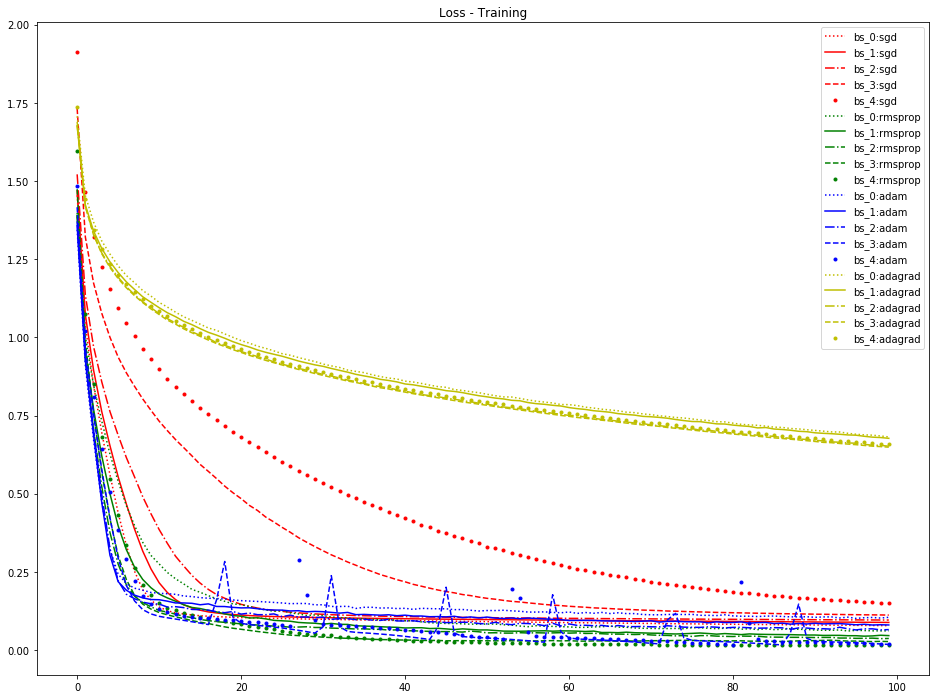

In [9]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(tra_loss["bs_0:sgd"][0])), tra_loss["bs_0:sgd"][0], ':',  label="bs_0:sgd", color="r")
plt.plot(range(len(tra_loss["bs_1:sgd"][0])), tra_loss["bs_1:sgd"][0], '-',  label="bs_1:sgd", color="r")
plt.plot(range(len(tra_loss["bs_2:sgd"][0])), tra_loss["bs_2:sgd"][0], '-.', label="bs_2:sgd", color="r")
plt.plot(range(len(tra_loss["bs_3:sgd"][0])), tra_loss["bs_3:sgd"][0], '--', label="bs_3:sgd", color="r")
plt.plot(range(len(tra_loss["bs_4:sgd"][0])), tra_loss["bs_4:sgd"][0], '.',  label="bs_4:sgd", color="r")

plt.plot(range(len(tra_loss["bs_0:rmsprop"][0])), tra_loss["bs_0:rmsprop"][0], ':',  label="bs_0:rmsprop", color="g")
plt.plot(range(len(tra_loss["bs_1:rmsprop"][0])), tra_loss["bs_1:rmsprop"][0], '-',  label="bs_1:rmsprop", color="g")
plt.plot(range(len(tra_loss["bs_2:rmsprop"][0])), tra_loss["bs_2:rmsprop"][0], '-.', label="bs_2:rmsprop", color="g")
plt.plot(range(len(tra_loss["bs_3:rmsprop"][0])), tra_loss["bs_3:rmsprop"][0], '--', label="bs_3:rmsprop", color="g")
plt.plot(range(len(tra_loss["bs_4:rmsprop"][0])), tra_loss["bs_4:rmsprop"][0], '.',  label="bs_4:rmsprop", color="g")

plt.plot(range(len(tra_loss["bs_0:adam"][0])), tra_loss["bs_0:adam"][0], ':',  label="bs_0:adam", color="b")
plt.plot(range(len(tra_loss["bs_1:adam"][0])), tra_loss["bs_1:adam"][0], '-',  label="bs_1:adam", color="b")
plt.plot(range(len(tra_loss["bs_2:adam"][0])), tra_loss["bs_2:adam"][0], '-.', label="bs_2:adam", color="b")
plt.plot(range(len(tra_loss["bs_3:adam"][0])), tra_loss["bs_3:adam"][0], '--', label="bs_3:adam", color="b")
plt.plot(range(len(tra_loss["bs_4:adam"][0])), tra_loss["bs_4:adam"][0], '.',  label="bs_4:adam", color="b")

plt.plot(range(len(tra_loss["bs_0:adagrad"][0])), tra_loss["bs_0:adagrad"][0], ':',  label="bs_0:adagrad", color="y")
plt.plot(range(len(tra_loss["bs_1:adagrad"][0])), tra_loss["bs_1:adagrad"][0], '-',  label="bs_1:adagrad", color="y")
plt.plot(range(len(tra_loss["bs_2:adagrad"][0])), tra_loss["bs_2:adagrad"][0], '-.', label="bs_2:adagrad", color="y")
plt.plot(range(len(tra_loss["bs_3:adagrad"][0])), tra_loss["bs_3:adagrad"][0], '--', label="bs_3:adagrad", color="y")
plt.plot(range(len(tra_loss["bs_4:adagrad"][0])), tra_loss["bs_4:adagrad"][0], '.',  label="bs_4:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

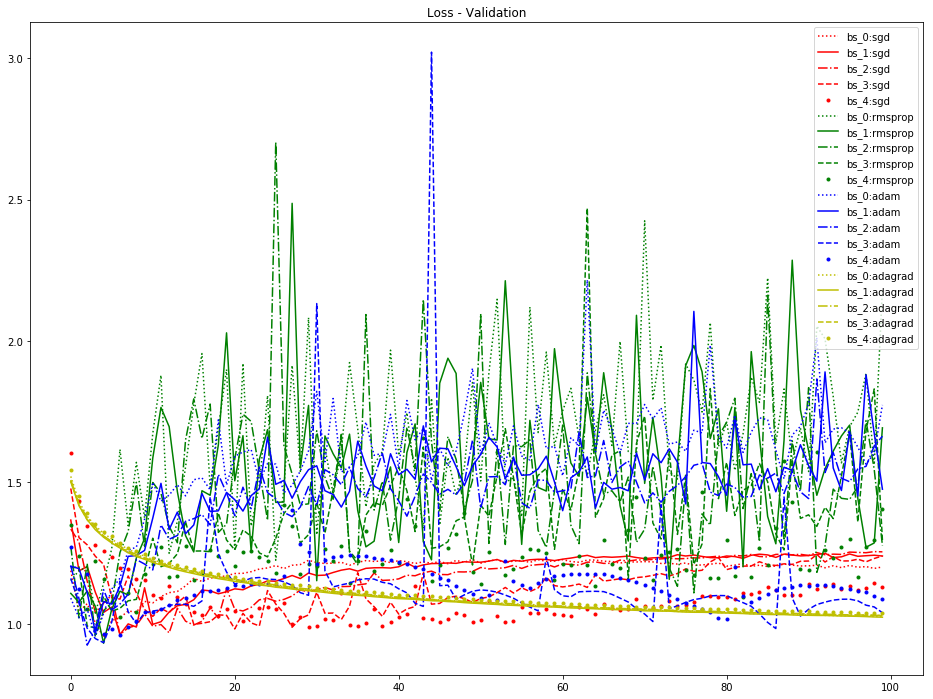

In [10]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(val_loss["bs_0:sgd"][0])), val_loss["bs_0:sgd"][0], ':',  label="bs_0:sgd", color="r")
plt.plot(range(len(val_loss["bs_1:sgd"][0])), val_loss["bs_1:sgd"][0], '-',  label="bs_1:sgd", color="r")
plt.plot(range(len(val_loss["bs_2:sgd"][0])), val_loss["bs_2:sgd"][0], '-.', label="bs_2:sgd", color="r")
plt.plot(range(len(val_loss["bs_3:sgd"][0])), val_loss["bs_3:sgd"][0], '--', label="bs_3:sgd", color="r")
plt.plot(range(len(val_loss["bs_4:sgd"][0])), val_loss["bs_4:sgd"][0], '.',  label="bs_4:sgd", color="r")

plt.plot(range(len(val_loss["bs_0:rmsprop"][0])), val_loss["bs_0:rmsprop"][0], ':',  label="bs_0:rmsprop", color="g")
plt.plot(range(len(val_loss["bs_1:rmsprop"][0])), val_loss["bs_1:rmsprop"][0], '-',  label="bs_1:rmsprop", color="g")
plt.plot(range(len(val_loss["bs_2:rmsprop"][0])), val_loss["bs_2:rmsprop"][0], '-.', label="bs_2:rmsprop", color="g")
plt.plot(range(len(val_loss["bs_3:rmsprop"][0])), val_loss["bs_3:rmsprop"][0], '--', label="bs_3:rmsprop", color="g")
plt.plot(range(len(val_loss["bs_4:rmsprop"][0])), val_loss["bs_4:rmsprop"][0], '.',  label="bs_4:rmsprop", color="g")

plt.plot(range(len(val_loss["bs_0:adam"][0])), val_loss["bs_0:adam"][0], ':',  label="bs_0:adam", color="b")
plt.plot(range(len(val_loss["bs_1:adam"][0])), val_loss["bs_1:adam"][0], '-',  label="bs_1:adam", color="b")
plt.plot(range(len(val_loss["bs_2:adam"][0])), val_loss["bs_2:adam"][0], '-.', label="bs_2:adam", color="b")
plt.plot(range(len(val_loss["bs_3:adam"][0])), val_loss["bs_3:adam"][0], '--', label="bs_3:adam", color="b")
plt.plot(range(len(val_loss["bs_4:adam"][0])), val_loss["bs_4:adam"][0], '.',  label="bs_4:adam", color="b")

plt.plot(range(len(val_loss["bs_0:adagrad"][0])), val_loss["bs_0:adagrad"][0], ':',  label="bs_0:adagrad", color="y")
plt.plot(range(len(val_loss["bs_1:adagrad"][0])), val_loss["bs_1:adagrad"][0], '-',  label="bs_1:adagrad", color="y")
plt.plot(range(len(val_loss["bs_2:adagrad"][0])), val_loss["bs_2:adagrad"][0], '-.', label="bs_2:adagrad", color="y")
plt.plot(range(len(val_loss["bs_3:adagrad"][0])), val_loss["bs_3:adagrad"][0], '--', label="bs_3:adagrad", color="y")
plt.plot(range(len(val_loss["bs_4:adagrad"][0])), val_loss["bs_4:adagrad"][0], '.',  label="bs_4:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

### Optimizer=Adam, batch_size=128 有較低的loss

## Plot accu history

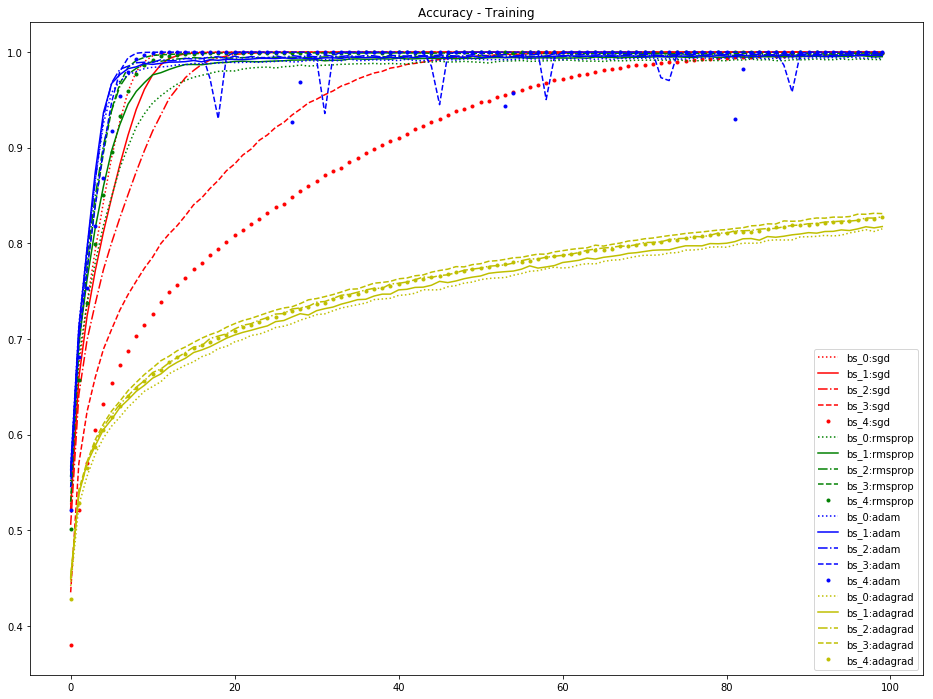

In [11]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(tra_accu["bs_0:sgd"][0])), tra_accu["bs_0:sgd"][0], ':',  label="bs_0:sgd", color="r")
plt.plot(range(len(tra_accu["bs_1:sgd"][0])), tra_accu["bs_1:sgd"][0], '-',  label="bs_1:sgd", color="r")
plt.plot(range(len(tra_accu["bs_2:sgd"][0])), tra_accu["bs_2:sgd"][0], '-.', label="bs_2:sgd", color="r")
plt.plot(range(len(tra_accu["bs_3:sgd"][0])), tra_accu["bs_3:sgd"][0], '--', label="bs_3:sgd", color="r")
plt.plot(range(len(tra_accu["bs_4:sgd"][0])), tra_accu["bs_4:sgd"][0], '.',  label="bs_4:sgd", color="r")

plt.plot(range(len(tra_accu["bs_0:rmsprop"][0])), tra_accu["bs_0:rmsprop"][0], ':',  label="bs_0:rmsprop", color="g")
plt.plot(range(len(tra_accu["bs_1:rmsprop"][0])), tra_accu["bs_1:rmsprop"][0], '-',  label="bs_1:rmsprop", color="g")
plt.plot(range(len(tra_accu["bs_2:rmsprop"][0])), tra_accu["bs_2:rmsprop"][0], '-.', label="bs_2:rmsprop", color="g")
plt.plot(range(len(tra_accu["bs_3:rmsprop"][0])), tra_accu["bs_3:rmsprop"][0], '--', label="bs_3:rmsprop", color="g")
plt.plot(range(len(tra_accu["bs_4:rmsprop"][0])), tra_accu["bs_4:rmsprop"][0], '.',  label="bs_4:rmsprop", color="g")

plt.plot(range(len(tra_accu["bs_0:adam"][0])), tra_accu["bs_0:adam"][0], ':',  label="bs_0:adam", color="b")
plt.plot(range(len(tra_accu["bs_1:adam"][0])), tra_accu["bs_1:adam"][0], '-',  label="bs_1:adam", color="b")
plt.plot(range(len(tra_accu["bs_2:adam"][0])), tra_accu["bs_2:adam"][0], '-.', label="bs_2:adam", color="b")
plt.plot(range(len(tra_accu["bs_3:adam"][0])), tra_accu["bs_3:adam"][0], '--', label="bs_3:adam", color="b")
plt.plot(range(len(tra_accu["bs_4:adam"][0])), tra_accu["bs_4:adam"][0], '.',  label="bs_4:adam", color="b")

plt.plot(range(len(tra_accu["bs_0:adagrad"][0])), tra_accu["bs_0:adagrad"][0], ':',  label="bs_0:adagrad", color="y")
plt.plot(range(len(tra_accu["bs_1:adagrad"][0])), tra_accu["bs_1:adagrad"][0], '-',  label="bs_1:adagrad", color="y")
plt.plot(range(len(tra_accu["bs_2:adagrad"][0])), tra_accu["bs_2:adagrad"][0], '-.', label="bs_2:adagrad", color="y")
plt.plot(range(len(tra_accu["bs_3:adagrad"][0])), tra_accu["bs_3:adagrad"][0], '--', label="bs_3:adagrad", color="y")
plt.plot(range(len(tra_accu["bs_4:adagrad"][0])), tra_accu["bs_4:adagrad"][0], '.',  label="bs_4:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

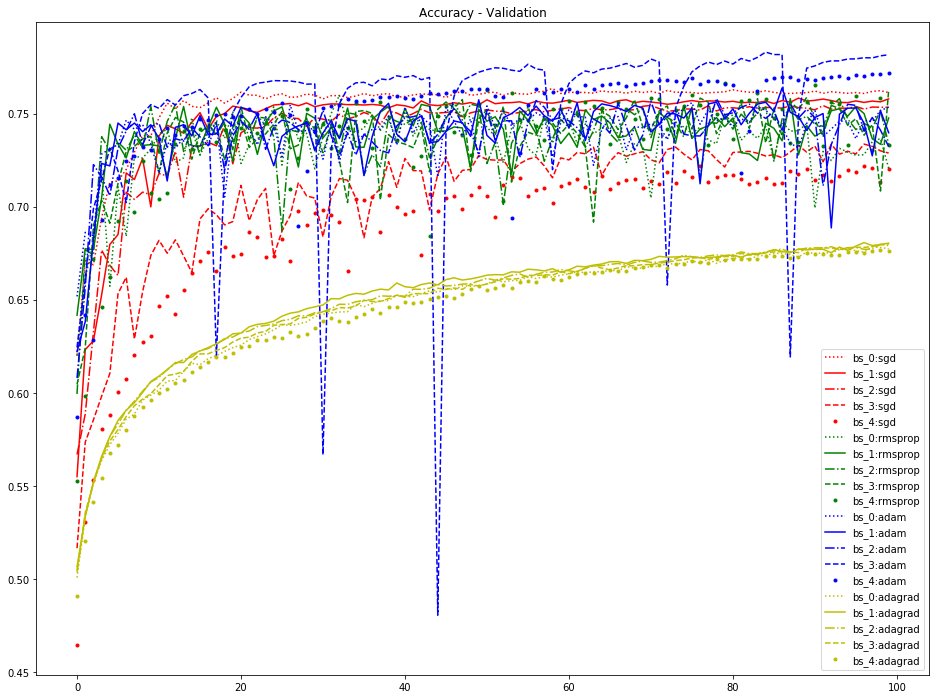

In [12]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(val_accu["bs_0:sgd"][0])), val_accu["bs_0:sgd"][0], ':',  label="bs_0:sgd", color="r")
plt.plot(range(len(val_accu["bs_1:sgd"][0])), val_accu["bs_1:sgd"][0], '-',  label="bs_1:sgd", color="r")
plt.plot(range(len(val_accu["bs_2:sgd"][0])), val_accu["bs_2:sgd"][0], '-.', label="bs_2:sgd", color="r")
plt.plot(range(len(val_accu["bs_3:sgd"][0])), val_accu["bs_3:sgd"][0], '--', label="bs_3:sgd", color="r")
plt.plot(range(len(val_accu["bs_4:sgd"][0])), val_accu["bs_4:sgd"][0], '.',  label="bs_4:sgd", color="r")

plt.plot(range(len(val_accu["bs_0:rmsprop"][0])), val_accu["bs_0:rmsprop"][0], ':',  label="bs_0:rmsprop", color="g")
plt.plot(range(len(val_accu["bs_1:rmsprop"][0])), val_accu["bs_1:rmsprop"][0], '-',  label="bs_1:rmsprop", color="g")
plt.plot(range(len(val_accu["bs_2:rmsprop"][0])), val_accu["bs_2:rmsprop"][0], '-.', label="bs_2:rmsprop", color="g")
plt.plot(range(len(val_accu["bs_3:rmsprop"][0])), val_accu["bs_3:rmsprop"][0], '--', label="bs_3:rmsprop", color="g")
plt.plot(range(len(val_accu["bs_4:rmsprop"][0])), val_accu["bs_4:rmsprop"][0], '.',  label="bs_4:rmsprop", color="g")

plt.plot(range(len(val_accu["bs_0:adam"][0])), val_accu["bs_0:adam"][0], ':',  label="bs_0:adam", color="b")
plt.plot(range(len(val_accu["bs_1:adam"][0])), val_accu["bs_1:adam"][0], '-',  label="bs_1:adam", color="b")
plt.plot(range(len(val_accu["bs_2:adam"][0])), val_accu["bs_2:adam"][0], '-.', label="bs_2:adam", color="b")
plt.plot(range(len(val_accu["bs_3:adam"][0])), val_accu["bs_3:adam"][0], '--', label="bs_3:adam", color="b")
plt.plot(range(len(val_accu["bs_4:adam"][0])), val_accu["bs_4:adam"][0], '.',  label="bs_4:adam", color="b")

plt.plot(range(len(val_accu["bs_0:adagrad"][0])), val_accu["bs_0:adagrad"][0], ':',  label="bs_0:adagrad", color="y")
plt.plot(range(len(val_accu["bs_1:adagrad"][0])), val_accu["bs_1:adagrad"][0], '-',  label="bs_1:adagrad", color="y")
plt.plot(range(len(val_accu["bs_2:adagrad"][0])), val_accu["bs_2:adagrad"][0], '-.', label="bs_2:adagrad", color="y")
plt.plot(range(len(val_accu["bs_3:adagrad"][0])), val_accu["bs_3:adagrad"][0], '--', label="bs_3:adagrad", color="y")
plt.plot(range(len(val_accu["bs_4:adagrad"][0])), val_accu["bs_4:adagrad"][0], '.',  label="bs_4:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

### Optimizer=Adam, batch_size=128有較好的準確率

## Focus on Adam

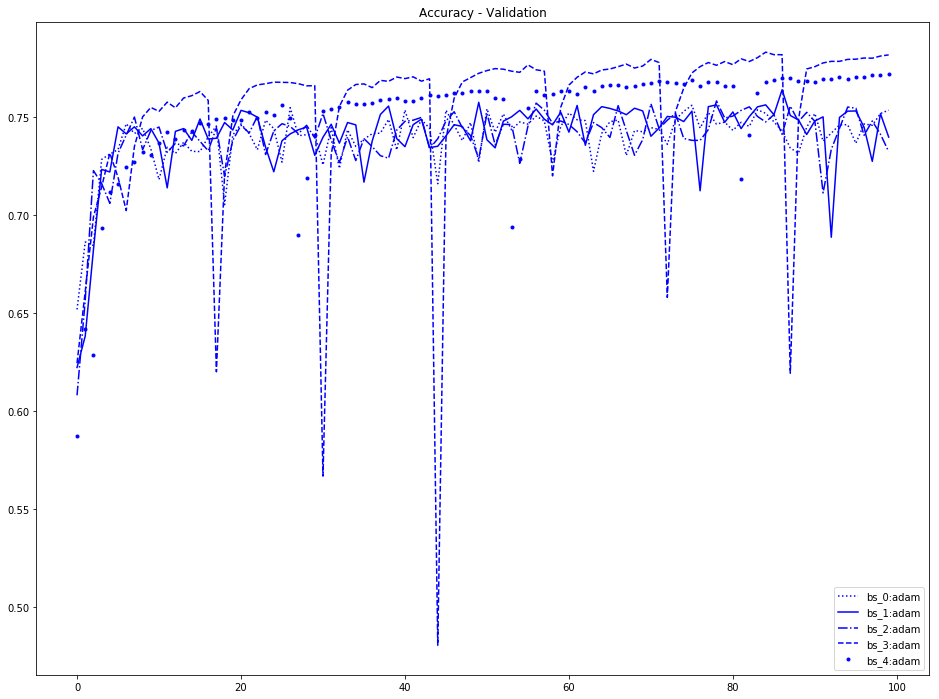

In [14]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(val_accu["bs_0:adam"][0])), val_accu["bs_0:adam"][0], ':',  label="bs_0:adam", color="b")
plt.plot(range(len(val_accu["bs_1:adam"][0])), val_accu["bs_1:adam"][0], '-',  label="bs_1:adam", color="b")
plt.plot(range(len(val_accu["bs_2:adam"][0])), val_accu["bs_2:adam"][0], '-.', label="bs_2:adam", color="b")
plt.plot(range(len(val_accu["bs_3:adam"][0])), val_accu["bs_3:adam"][0], '--', label="bs_3:adam", color="b")
plt.plot(range(len(val_accu["bs_4:adam"][0])), val_accu["bs_4:adam"][0], '.',  label="bs_4:adam", color="b")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

In [13]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white